### Problem Statement
Here we need to train a regression model to estimate the delivery time for Delivery app, a marketplace for intra-city logistics in India. The goal is to provide customers with an estimated delivery time based on various factors, including the items being ordered, the location they are being delivered from, and the available delivery partners.

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = pd.read_csv('')
data.head(5)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [3]:
len(data)

197428

## Column Profiling:


    market_id : integer id for the market where the restaurant lies
    created_at : the timestamp at which the order was placed
    actual_delivery_time : the timestamp when the order was delivered
    store_primary_category : category for the restaurant
    order_protocol : integer code value for order protocol(how the order was placed ie:  call to restaurant, pre booked, third part etc)
    total_items : total items in the order
    subtotal : final price of the order
    num_distinct_items : the number of distinct items in the order
    min_item_price : price of the cheapest item in the order
    max_item_price : price of the costliest item in order
    total_onshift_partners : number of delivery partners on duty at the time order was placed
    total_busy_partners : number of delivery partners attending to other tasks
    total_outstanding_orders : total number of orders to be fulfilled at the moment


In [4]:
data.info() #This method prints information about a DataFrame including the index dtype and columns, 
#non-null values and memory usage.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

## Finding Outliers

In [5]:
p_25 = data["total_items"].quantile(0.25) 
p_50 = data["total_items"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["total_items"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean total_items is {}'.format(data["total_items"].mean()))
print('Median total_items is {}'.format(data["total_items"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in total_items column are {} and {} respectively.  '\
      .format(data["total_items"].min(),data["total_items"].max()))

Mean total_items is 3.196390582896043
Median total_items is 3.0
lower limit : 0 , upper limt : 10.0

Min and max values in total_items column are 1 and 411 respectively.  


In [6]:
#There are  oultliers in total_items
print(len(data[data['total_items'] < lower ]),len(data[data['total_items'] > upper ]) )

0 3393


In [7]:
# percentage of ouliers in total_items:
len(data[data['total_items'] > upper ])/len(data) * 100

1.7186012115809306

In [8]:
#removing outliers:
data = data[data.total_items <= upper]

Median total_items : 3.0


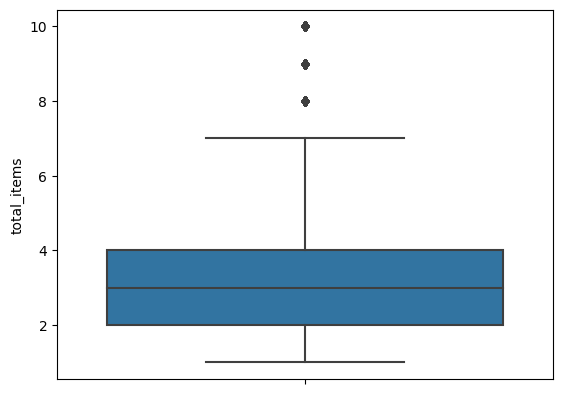

In [9]:
sns.boxplot( y=data["total_items"] )
print("Median total_items :",data["total_items"].median())

In [10]:
p_25 = data["subtotal"].quantile(0.25) 
p_50 = data["subtotal"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["subtotal"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean subtotal is {}'.format(data["subtotal"].mean()))
print('Median subtotal is {}'.format(data["subtotal"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in subtotal column are {} and {} respectively.  '\
      .format(data["subtotal"].min(),data["subtotal"].max()))

Mean subtotal is 2618.0897415414743
Median subtotal is 2198.0
lower limit : 0 , upper limt : 9180.0

Min and max values in subtotal column are 0 and 15960 respectively.  


In [11]:
#There are  oultliers in subtotal 
print(len(data[data['subtotal'] < lower ]),len(data[data['subtotal'] > upper ]) )

0 1358


In [12]:
# percentage of ouliers in total_items:
len(data[data['subtotal'] > upper ])/len(data) * 100

0.699873734120133

In [13]:
#removing outliers:
data = data[data.subtotal <= upper]

Median subtotal : 2190.0


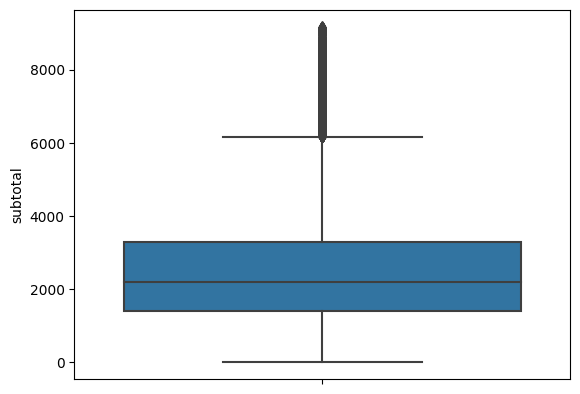

In [14]:
sns.boxplot( y=data["subtotal"] )
print("Median subtotal :",data["subtotal"].median())

In [15]:
p_25 = data["min_item_price"].quantile(0.25) 
p_50 = data["min_item_price"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["min_item_price"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean min_item_price is {}'.format(data["min_item_price"].mean()))
print('Median min_item_price is {}'.format(data["min_item_price"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in min_item_price column are {} and {} respectively.  '\
      .format(data["min_item_price"].min(),data["min_item_price"].max()))

Mean min_item_price is 693.5467751729578
Median min_item_price is 599.0
lower limit : 0 , upper limt : 2900.0

Min and max values in min_item_price column are -86 and 8959 respectively.  


In [16]:
#There are  oultliers in min_item_price 
print(len(data[data['min_item_price'] < lower ]),len(data[data['min_item_price'] > upper ]) )

6 1174


In [17]:
#removing outliers:
data = data[(data.min_item_price <= upper) & (data.min_item_price >= lower)]

Median min_item_price : 595.0


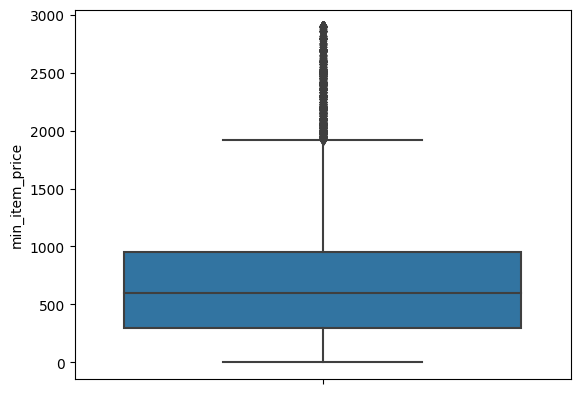

In [18]:
sns.boxplot( y=data["min_item_price"] )
print("Median min_item_price :",data["min_item_price"].median())

In [19]:
p_25 = data["max_item_price"].quantile(0.25) 
p_50 = data["max_item_price"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["max_item_price"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean max_item_price is {}'.format(data["max_item_price"].mean()))
print('Median max_item_price is {}'.format(data["max_item_price"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in max_item_price column are {} and {} respectively.  '\
      .format(data["max_item_price"].min(),data["max_item_price"].max()))

Mean max_item_price is 1140.8991472451266
Median max_item_price is 1093.0
lower limit : 0 , upper limt : 3180.0

Min and max values in max_item_price column are 0 and 8500 respectively.  


In [20]:
#There are  oultliers in max_item_price 
print(len(data[data['max_item_price'] < lower ]),len(data[data['max_item_price'] > upper ]) )

0 816


In [21]:
#removing outliers:
data = data[data.max_item_price <= upper]

Median max_item_price : 1079.0


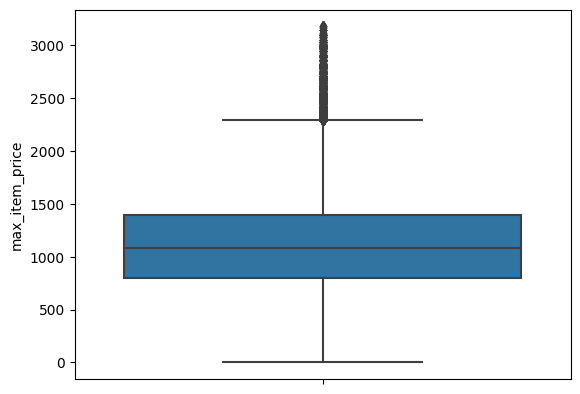

In [22]:
sns.boxplot( y=data["max_item_price"] )
print("Median max_item_price :",data["max_item_price"].median())

In [23]:
p_25 = data["total_onshift_partners"].quantile(0.25) 
p_50 = data["total_onshift_partners"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["total_onshift_partners"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean total_onshift_partners is {}'.format(data["total_onshift_partners"].mean()))
print('Median total_onshift_partners is {}'.format(data["total_onshift_partners"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in total_onshift_partners column are {} and {} respectively.  '\
      .format(data["total_onshift_partners"].min(),data["total_onshift_partners"].max()))

Mean total_onshift_partners is 44.81453129734334
Median total_onshift_partners is 37.0
lower limit : 0 , upper limt : 209.0

Min and max values in total_onshift_partners column are -4.0 and 171.0 respectively.  


In [24]:
#There are  oultliers in total_onshift_partners 
print(len(data[data['total_onshift_partners'] < lower ]),len(data[data['total_onshift_partners'] > upper ]) )

21 0


In [25]:
#removing outliers:
data = data[data.total_onshift_partners >= lower]

Median total_onshift_partners : 37.0


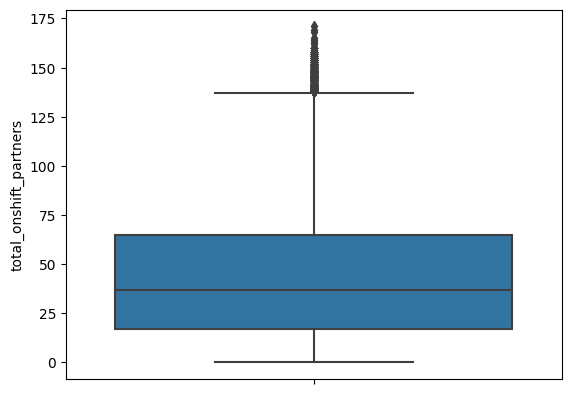

In [26]:
sns.boxplot( y=data["total_onshift_partners"] )
print("Median total_onshift_partners :",data["total_onshift_partners"].median())

In [27]:
p_25 = data["total_busy_partners"].quantile(0.25) 
p_50 = data["total_busy_partners"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["total_busy_partners"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean total_busy_partners is {}'.format(data["total_busy_partners"].mean()))
print('Median total_busy_partners is {}'.format(data["total_busy_partners"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in total_busy_partners column are {} and {} respectively.  '\
      .format(data["total_busy_partners"].min(),data["total_busy_partners"].max()))

Mean total_busy_partners is 41.75174101476289
Median total_busy_partners is 34.0
lower limit : 0 , upper limt : 203.0

Min and max values in total_busy_partners column are -5.0 and 154.0 respectively.  


In [28]:
#There are  oultliers in total_busy_partners 
print(len(data[data['total_busy_partners'] < lower ]),len(data[data['total_busy_partners'] > upper ]) )

18 0


In [29]:
#removing outliers:
data = data[data.total_busy_partners >= lower]

Median total_busy_partners : 34.0


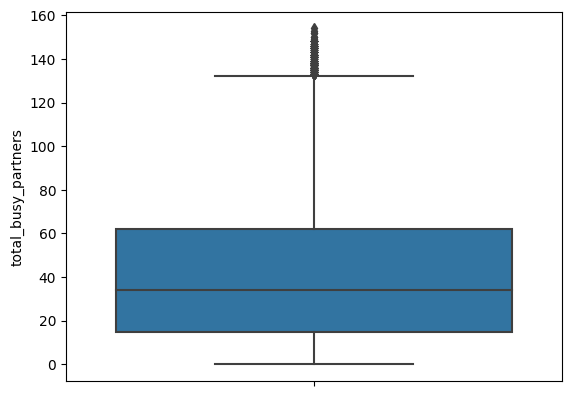

In [30]:
sns.boxplot( y=data["total_busy_partners"] )
print("Median total_busy_partners :",data["total_busy_partners"].median())

In [31]:
p_25 = data["total_outstanding_orders"].quantile(0.25) 
p_50 = data["total_outstanding_orders"].quantile(0.5)  # Q2 or p_50 or median
p_75 = data["total_outstanding_orders"].quantile(0.75)

iqr = p_75 - p_25
lower = max(0,(p_25 - 3 * iqr))
upper = p_75 + 3 * iqr

print('Mean total_outstanding_orders is {}'.format(data["total_outstanding_orders"].mean()))
print('Median total_outstanding_orders is {}'.format(data["total_outstanding_orders"].median()))
print('lower limit : {} , upper limt : {}'.format(lower,upper))
print()
print('Min and max values in total_outstanding_orders column are {} and {} respectively.  '\
      .format(data["total_outstanding_orders"].min(),data["total_outstanding_orders"].max()))

Mean total_outstanding_orders is 58.04464775846294
Median total_outstanding_orders is 41.0
lower limit : 0 , upper limt : 289.0

Min and max values in total_outstanding_orders column are -6.0 and 283.0 respectively.  


In [32]:
#There are  oultliers in total_outstanding_orders  
print(len(data[data['total_outstanding_orders'] < lower ]),len(data[data['total_outstanding_orders'] > upper ]) )

40 0


In [33]:
#removing outliers:
data = data[data.total_outstanding_orders >= lower]

Median total_outstanding_orders : 41.0


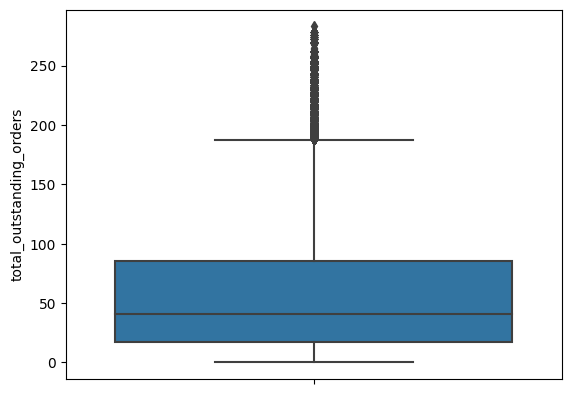

In [34]:
sns.boxplot( y=data["total_outstanding_orders"] )
print("Median total_outstanding_orders :",data["total_outstanding_orders"].median())

## Analysing Categorical Features

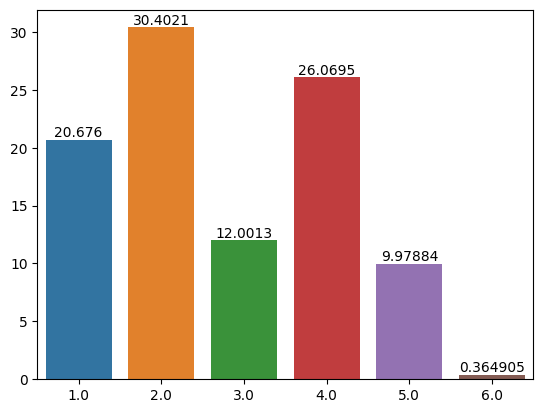

In [35]:
# Market 2 is having height percentage of orders : 30.4% 
# Market 6 is having lowest percentage of orders : 0.36%
market_id = data['market_id'].value_counts()/len(data) * 100
ax = sns.barplot(x=market_id.index, y=market_id.values)
for i in ax.containers:
    ax.bar_label(i,)

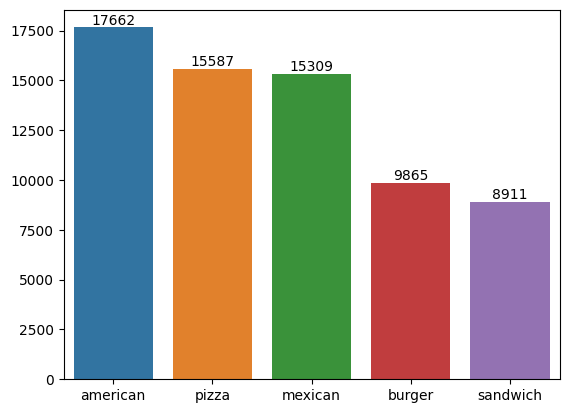

In [36]:
# Top 5 store_primary_category:
store_primary_category = data['store_primary_category'].value_counts()[:5]
ax = sns.barplot(x=store_primary_category.index, y=store_primary_category.values)
for i in ax.containers:
    ax.bar_label(i,)

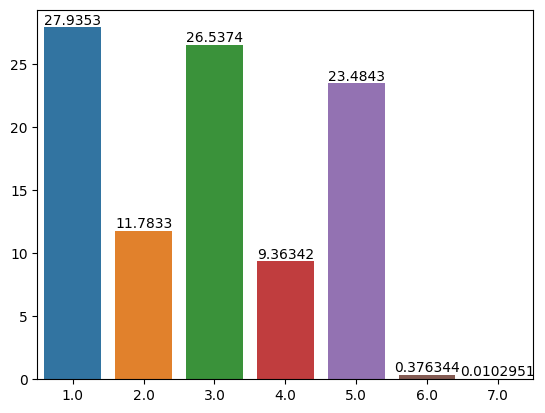

In [37]:
# Most orders are placed through order protocol 1, 3 and 5
# protocol 6 and 7 has least orders  
order_protocol = data['order_protocol'].value_counts()/len(data) * 100
ax = sns.barplot(x=order_protocol.index, y=order_protocol.values)
for i in ax.containers:
    ax.bar_label(i,)

### Creating Target column:

In [38]:
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])

In [39]:
data['hour_of_day'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.dayofweek

In [40]:
data['Target'] = data['actual_delivery_time'] - data['created_at']
data['Target'] = data['Target'].dt.total_seconds() / 60
data['Target'] = data['Target'].round(2)

In [41]:
# Top hours of day during which orders are placed are:
# 2,1,3,20 and 4 
data['hour_of_day'].value_counts()[:5]

C:\Users\1267\AppData\Local\Temp\ipykernel_18212\3909868341.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['hour_of_day'].value_counts()[:5]


2     32681
1     25244
3     23605
20    14004
4     13224
Name: hour_of_day, dtype: int64

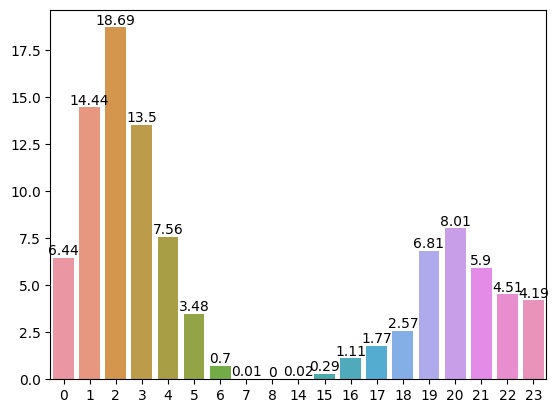

In [42]:
# Percentage of orders at each hour of the day:
hour_of_day = round(data['hour_of_day'].value_counts()/len(data) * 100,2)
ax = sns.barplot(x=hour_of_day.index, y=hour_of_day.values)
for i in ax.containers:
    ax.bar_label(i,)

In [43]:
# After hour 2 we can see oeders decreasing exponentially till hour 6
# After hour 15 we can see oeders increasing exponentially till hour 20

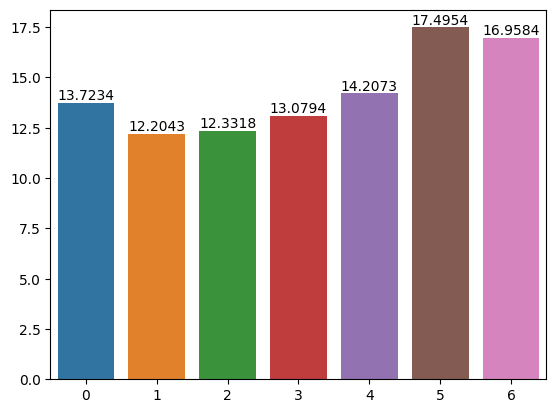

In [44]:
# Most orders are happening in the weekends.
day_of_week = data['day_of_week'].value_counts()/len(data) * 100
ax = sns.barplot(x=day_of_week.index, y=day_of_week.values)
for i in ax.containers:
    ax.bar_label(i,)

In [45]:
len(data['store_id'].unique())

5749

In [46]:
# sice there are 5749 stores we can ignore that column
# we can also remove date time columns
data = data.drop(['created_at','store_id','actual_delivery_time'], axis=1)
data.head(2)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour_of_day,day_of_week,Target
0,1.0,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,22,4,62.98
1,2.0,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,21,1,67.07


### Finding Missing Values

In [47]:
data.isnull().sum()

market_id                    887
store_primary_category      4049
order_protocol               891
total_items                    0
subtotal                       0
num_distinct_items             0
min_item_price                 0
max_item_price                 0
total_onshift_partners         0
total_busy_partners            0
total_outstanding_orders       0
hour_of_day                    0
day_of_week                    0
Target                         7
dtype: int64

In [48]:
# Remove rows with null values in column 'Target'
data = data.dropna(subset=['Target'])

In [49]:
#Total null values in each column in %
total =   round((data.isna().sum()/len(data))*100 ,2)
for i,v in enumerate(total):
    if v> 0:
        print(total.index[i],':',v,'%')

market_id : 0.51 %
store_primary_category : 2.32 %
order_protocol : 0.51 %


# Handling Missing Values:

In [50]:
#Divide data in X and y

y = data['Target']
X = data.drop(['Target'], axis = 1)

### Identify Categorical Features:

In [51]:
categorical_features = X.select_dtypes(include = ['object']).columns.values
categorical_features

array(['store_primary_category'], dtype=object)

In [52]:
X[categorical_features].head(2)

,store_primary_category
0,american
1,mexican


In [53]:
cat_impute = SimpleImputer(strategy='constant', fill_value = 'mean')
cat_impute.fit(X[categorical_features])
X[categorical_features] = cat_impute.transform(X[categorical_features])

In [54]:
X[categorical_features].isnull().sum()

store_primary_category    0
dtype: int64

### Numerical features:

In [55]:
numerical_features = X.select_dtypes(include = ['int64','float64']).columns.values
numerical_features

array(['market_id', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'hour_of_day', 'day_of_week'],
      dtype=object)

In [56]:
num_impute = KNNImputer()
num_impute.fit(X[numerical_features])
X[numerical_features] = num_impute.transform(X[numerical_features])

In [57]:
X.isnull().sum()

market_id                   0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
hour_of_day                 0
day_of_week                 0
dtype: int64

In [58]:
len(X),len(y)

(174833, 174833)

In [59]:
for col in X.columns:
    if col in categorical_features:
        X[col] = LabelEncoder().fit_transform(X[col])

In [61]:
X.head(2)

,market_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,hour_of_day,day_of_week
0,1.0,4,1.0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,22.0,4.0
1,2.0,47,2.0,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,21.0,1.0


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [63]:
X_train.shape, X_test.shape

((139866, 13), (34967, 13))

In [64]:
scaler = preprocessing.StandardScaler()

In [65]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest regressor model

In [66]:

rf_model = RandomForestRegressor()

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [67]:
# Use the best model to make predictions
predictions = rf_model.predict(X_test_scaled)

In [68]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1319.7302521226452
Root Mean Squared Error: 36.328091776511535
Mean Absolute Error: 11.763940126813443


In [69]:
predictions[:5]

array([54.6441, 38.5846, 49.3677, 39.5669, 60.9054])

In [70]:
y_test[:5]

C:\Users\1267\AppData\Local\Temp\ipykernel_18212\1754177261.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test[:5]


92999     64.23
163276    34.95
119350    51.00
96333     38.33
174641    89.75
Name: Target, dtype: float64

# Neural Network Model:

In [71]:
input_dim = X_test_scaled.shape[1]

In [90]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),  # Adjust input_dim to match your input feature size
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, verbose = True)

Epoch 1/15
4371/4371 [==============================] - 34s 7ms/step - loss: 989.6633
Epoch 2/15
4371/4371 [==============================] - 30s 7ms/step - loss: 624.3481
Epoch 3/15
4371/4371 [==============================] - 29s 7ms/step - loss: 613.5824
Epoch 4/15
4371/4371 [==============================] - 27s 6ms/step - loss: 604.4163
Epoch 5/15
4371/4371 [==============================] - 29s 7ms/step - loss: 598.7262
Epoch 6/15
4371/4371 [==============================] - 28s 6ms/step - loss: 594.0978
Epoch 7/15
4371/4371 [==============================] - 29s 7ms/step - loss: 589.2460
Epoch 8/15
4371/4371 [==============================] - 29s 7ms/step - loss: 584.8557
Epoch 9/15
4371/4371 [==============================] - 30s 7ms/step - loss: 579.4586
Epoch 10/15
4371/4371 [==============================] - 30s 7ms/step - loss: 577.4224
Epoch 11/15
4371/4371 [==============================] - 29s 7ms/step - loss: 570.9773
Epoch 12/15
4371/4371 [=============================

In [91]:
predictions = model.predict(X_test_scaled)

1093/1093 [==============================] - 1s 1ms/step


In [92]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1372.2401516543098
Root Mean Squared Error: 37.043759955683626
Mean Absolute Error: 11.690184214614316


# Hyperparameter tuning:

In [77]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [81]:
def create_model(units=32, activation='relu'):
    model = Sequential()
    model.add(Dense(units=units, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create KerasRegressor
model = KerasRegressor(build_fn=create_model)

# Define the hyperparameters grid for tuning
param_grid = {
    'units': [32, 64, 128],
    'activation': ['relu', 'sigmoid']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=KFold(n_splits=5))
grid_search.fit(X_train_scaled, y_train)

C:\Users\1267\AppData\Local\Temp\ipykernel_18212\2502980875.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


4371/4371 [==============================] - 19s 4ms/step - loss: 663.1681


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000001CEBED01750>,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'units': [32, 64, 128]})

In [83]:
# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [85]:
# Evaluate the best model on the test set
predictions = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
print("Best Parameters: ", best_params)

1093/1093 [==============================] - 4s 3ms/step
Best Parameters:  {'activation': 'relu', 'units': 128}


In [86]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1389.276443000417
Root Mean Squared Error: 37.27299884635548
Mean Absolute Error: 12.179712738727458


# Leading Questions:

#### 1. Defining the problem statements and where can this and modifications of this be used?
Ans: Here we need to train a regression model to estimate the delivery time for a delivery app, a marketplace for intra-city logistics in India. The goal is to provide customers with an estimated delivery time based on various factors, including the items being ordered, the location they are being delivered from, and the available delivery partners.

#### 2.List 3 functions the pandas datetime provides with one line explanation.
1) to_datetime : Converts a string to a pandas datetime object.
2) dt.hour : function is used to extract the hour component from a datetime object.
3) dt.dayofweek : function is used to extract the day of the week from a datetime object

#### 3.Short note on datetime, timedelta, time span (period)
1. datetime : The datetime class is used to represent a specific date and time, while the date and time classes are used to represent only the date or time component, respectively.With the datetime module, you can perform operations such as date arithmetic, formatting, parsing, and extracting specific components like year, month, day, hour, minute, and second.
2. timedelta : The timedelta class in Python represents a duration or difference between two dates or times. It allows you to perform arithmetic operations on dates and times, such as adding or subtracting a specific duration. The timedelta class accepts arguments for days, seconds, microseconds, milliseconds, minutes, hours, and weeks.
3. Period : the Period class is provided to handle time spans. It allows you to work with a fixed frequency of time, such as daily, monthly, or yearly intervals. The Period class provides methods to perform operations like arithmetic, converting to and from other time representations, and extracting components such as year, month, day, etc.

#### 4.Why do we need to check for outliers in our data?
Ans: Outliers can have a significant impact on statistical analyses and modeling. They can distort the distribution of the data, affect measures of central tendency. By identifying and handling outliers appropriately, we can obtain more accurate and reliable statistical results.Outliers can adversely affect the performance and generalization ability of machine learning models. Models may overfit or underfit the data if outliers are not properly handled. Outliers can also introduce bias or noise into the model

#### 5.Name 3 outlier removal methods?
1. IQR : IQR method uses the interquartile range to identify outliers. The IQR is the range between the 25th percentile (Q1) and the 75th percentile (Q3) of the data. Any data point that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR is considered an outlier and can be removed.
2. DBSCAN : DBSCAN is a density-based clustering algorithm that can be adapted for outlier detection. It identifies outliers as data points that fall in low-density regions, away from clusters.
3. Isolation Forest : Isolation Forest algorithm is a tree-based ensemble method specifically designed for outlier detection. It isolates outliers by randomly partitioning the data into subsets and isolating them in smaller and smaller partitions.

#### 6. What classical machine learning methods can we use other than random forest for regression?
Ans: For regression tasks we can use Linear Regression, Support Vector Regression, K-nearest Neighbours Regression and Decision Tree Regression

#### 7. Why is scaling required for neural networks?
Ans: When the input features have different scales, it can result in gradients that are too large or too small during backpropagation. Large gradients may cause unstable training or result in the "exploding gradient" problem. Small gradients may lead to slow convergence or the "vanishing gradient" problem. Scaling the input features to a similar range can lead to faster convergence during training. It can help the optimization algorithm find the optimal weights more efficiently by ensuring that each feature contributes proportionally to the overall loss function.

#### 8. Briefly explain your choice of optimizer?
Ans: Adam - It is an adaptive optimization algorithm that computes adaptive learning rates for each parameter. It combines the benefits of both AdaGrad and RMSprop.

#### 9. Which activation function did you use and why?
Ans: ReLU: It is a simple activation function compared to other alternatives like sigmoid or tanh. It only activates only if the input is positive, and it is zero otherwise. This simplicity leads to faster computations and easier implementation in neural network architectures.

#### 10. Why does a neural network perform well on a large dataset?
Ans: Training a neural network on a large dataset typically requires significant computational resources. With advancements in hardware and access to high-performance computing, training larger networks on larger datasets becomes feasible. This increased computational capacity allows for more complex models and deeper architectures, which can capture and learn intricate patterns and relationships in the data.With a larger dataset, there is more variation and diversity in the training examples, making it harder for the model to memorize the data and forcing it to focus on generalizable patterns.